In [1]:
getwd()
if ( is.null(environment()$this_notebook_dir) ) {
    this_notebook_dir <- getwd()
    setwd(paste0(getwd(), '/..'))
}
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/NA_fix"

[1] "/mnt/hdd/develop/kaggle/house-prices/R"

In [3]:
source('helpers.R')
source('validation_utils.R')

kaggle.house.loadLibraries()
data <- kaggle.house.loadData()

data$combined %>% 
select(-dataSource) %>% 
filter(!is.na(LotFrontage)) %>% 
mutate(
    LotFrontage.log = log(LotFrontage),
    LotArea.log = log(LotArea)
) -> df.LotFrontage

dataset <- df.LotFrontage %>% select(LotFrontage.log, LotArea.log, MSSubClass, Neighborhood)
dataset %>% dim

[1] 2433    4

In [13]:
?rmse

In [6]:
train_test_cycle <- function (dataset, target_var_name, data_preparator, model_maker) {
    
    train_index <- caret::createDataPartition(
                        dataset[, target_var_name] %>% `[[`(1), 
                        p=0.6, times=1, list=FALSE)

    trainset <- dataset[train_index,]
    testset <- dataset[-train_index,]
    
    # ==========
    tmp <- data_preparator(trainset, testset)
    trainset <- tmp$trainset
    testset <- tmp$testset
    
    model <- model_maker(trainset)
    # ==========
    
    y_test_predicted <- predict(model, testset)
    y_test_actual <- testset[, target_var_name] %>% `[[`(1)

    train_score <- sum(model$residuals^2) / length(model$residuals)
    test_score <- sum( (y_test_predicted - y_test_actual)^2 ) / length(y_test_actual)

    list(
        model = model,
        train_score = train_score, 
        test_score = test_score,
        trainset = trainset,
        testset = testset
    )   
}

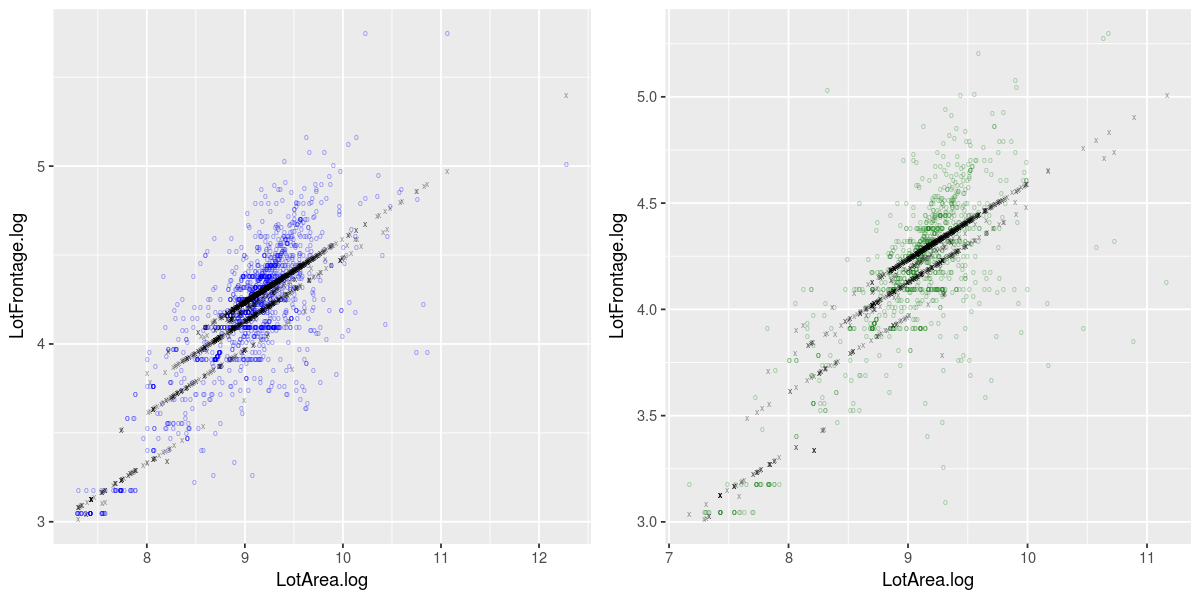

In [50]:
data_preparator <- function (trainset, testset) {
    
    trainset.new <- trainset %>%
    group_by(MSSubClass) %>%
    mutate(MSSubClass.avg = median(LotFrontage.log))

    train_group_avg <- trainset.new %>% summarise(MSSubClass.avg=max(MSSubClass.avg))
    train_global_avg <- trainset.new %>% ungroup %>% summarise(avg=max(MSSubClass.avg)) %>% `$`('avg')

    testset.new <- testset %>% left_join(train_group_avg, by='MSSubClass')
    testset.new[is.na(testset.new$MSSubClass.avg), "MSSubClass.avg"] <- train_global_avg

    list(trainset = trainset.new, testset = testset.new)
}

model_maker <- function (trainset) {
    lm(LotFrontage.log ~ LotArea.log + MSSubClass.avg, data = trainset)
}

results <- train_test_cycle(
    dataset = dataset, 
    target_var_name = "LotFrontage.log", 
    data_preparator = data_preparator, 
    model_maker = model_maker
)

model.augment <- broom::augment(results$model)
 
p1 <- model.augment %>% 
ggplot() + 
geom_point(aes(x=LotArea.log, y=LotFrontage.log), alpha=0.4, color="blue", shape='o') +
geom_point(aes(x=LotArea.log, y=.fitted), alpha=0.4, color="black", shape='x')

p2 <- results$testset %>%
ggplot() + 
geom_point(aes(x=LotArea.log, y=LotFrontage.log), alpha=0.4, color="forestgreen", shape='o') +
geom_point(aes(x=LotArea.log, y=predict(results$model, results$testset)), alpha=0.4, color="black", shape='x')


options(repr.plot.width = 10, repr.plot.height = 5)
grid.arrange(p1, p2,
    layout_matrix=rbind(c(1, 2))
)

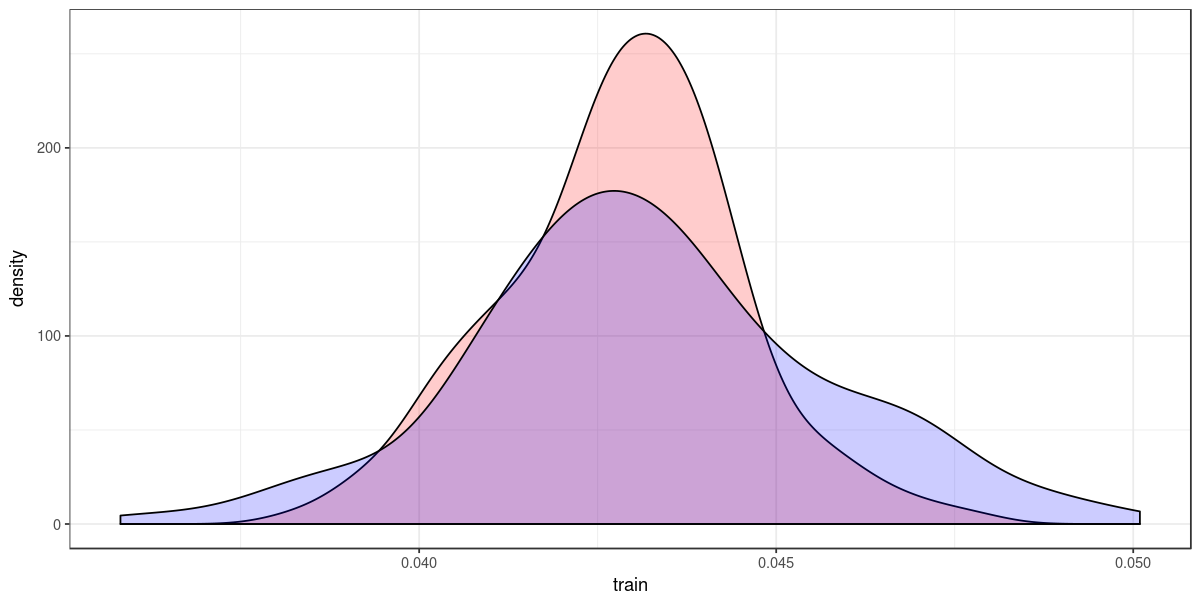

In [49]:
1:200 %>% purrr::map(function (i) {
    
    r <- train_test_cycle(
            dataset = dataset, 
            target_var_name = "LotFrontage.log", 
            data_preparator = data_preparator, 
            model_maker = model_maker)
    list(
        model = r$model,
        train_score = r$train_score, 
        test_score = r$test_score
    )  
}) -> result

scores <- tibble(
    train = result %>% map_dbl(~.$train_score),
    test = result %>% map_dbl(~.$test_score)
)

scores %>% ggplot() +
geom_density(aes(train), fill = "red", alpha = "0.2") +
geom_density(aes(test), fill = "blue", alpha = "0.2") +
theme_bw()

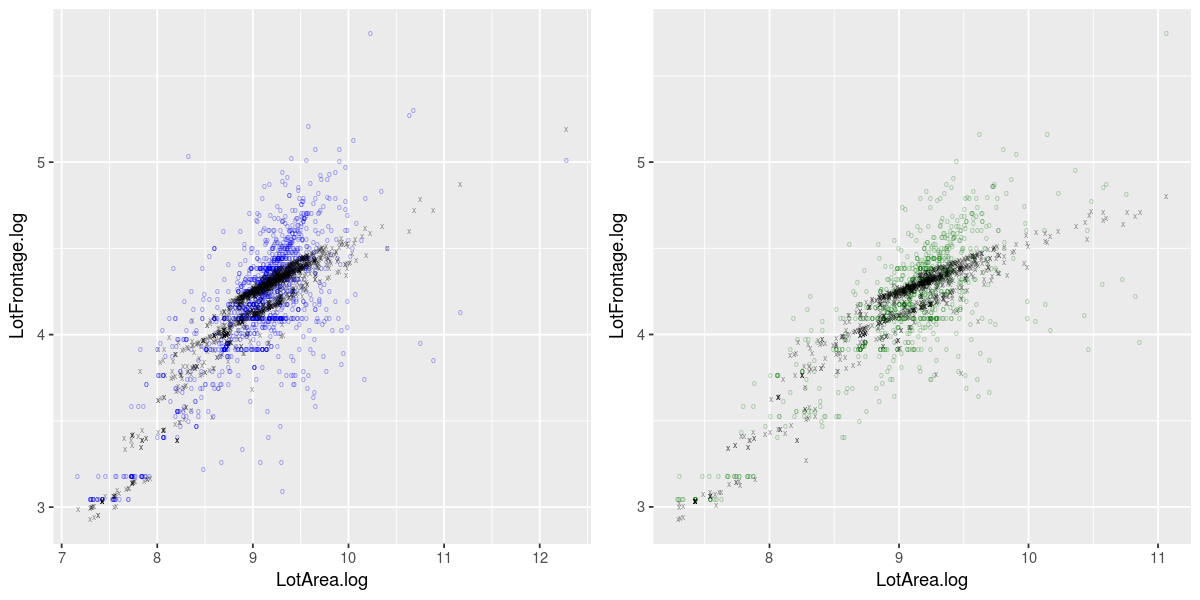

In [57]:
data_preparator <- function (trainset, testset) {
    
    trainset.new <- trainset %>%
    group_by(MSSubClass) %>%
    mutate(MSSubClass.avg = median(LotFrontage.log))

    train_group_avg <- trainset.new %>% summarise(MSSubClass.avg=max(MSSubClass.avg))
    train_global_avg <- trainset.new %>% ungroup %>% summarise(avg=max(MSSubClass.avg)) %>% `$`('avg')

    testset.new <- testset %>% left_join(train_group_avg, by='MSSubClass')
    testset.new[is.na(testset.new$MSSubClass.avg), "MSSubClass.avg"] <- train_global_avg
    
    
    trainset.new <- trainset.new %>%
    group_by(Neighborhood) %>%
    mutate(Neighborhood.avg = median(LotFrontage.log))
    
    train_group_avg <- trainset.new %>% summarise(Neighborhood.avg=max(Neighborhood.avg))
    train_global_avg <- trainset.new %>% ungroup %>% summarise(avg=max(Neighborhood.avg)) %>% `$`('avg')

    testset.new <- testset.new %>% left_join(train_group_avg, by='Neighborhood')
    testset.new[is.na(testset.new$Neighborhood.avg), "Neighborhood.avg"] <- train_global_avg
    

    list(trainset = trainset.new, testset = testset.new)
}

model_maker <- function (trainset) {
    lm(LotFrontage.log ~ LotArea.log + MSSubClass.avg + Neighborhood.avg, data = trainset)
}

results <- train_test_cycle(
    dataset = dataset, 
    target_var_name = "LotFrontage.log", 
    data_preparator = data_preparator, 
    model_maker = model_maker
)

model.augment <- broom::augment(results$model)
 
p1 <- model.augment %>% 
ggplot() + 
geom_point(aes(x=LotArea.log, y=LotFrontage.log), alpha=0.4, color="blue", shape='o') +
geom_point(aes(x=LotArea.log, y=.fitted), alpha=0.4, color="black", shape='x')

p2 <- results$testset %>%
ggplot() + 
geom_point(aes(x=LotArea.log, y=LotFrontage.log), alpha=0.4, color="forestgreen", shape='o') +
geom_point(aes(x=LotArea.log, y=predict(results$model, results$testset)), alpha=0.4, color="black", shape='x')


options(repr.plot.width = 10, repr.plot.height = 5)
grid.arrange(p1, p2,
    layout_matrix=rbind(c(1, 2))
)